# Titanic: Machine Learning from Disaster

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 1. Load Data

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [2]:
train_path = "data/train.csv"
test_path = "data/test.csv"

In [3]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.shape

(891, 12)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


## 2. Missing Values Analysis

In [8]:
# we have a lot of missing values in Age and Cabin
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
# there is a very high overlap of missing values in both columns
train[ (train["Age"].isna()) & (train["Cabin"].isna())].shape[0]

158

**Obervation** It looks like we have a lot of missing values. In the feature cabin, 687 values are missing.
Generally these are some ways how to deal with missing values:
* Drop Rows with missing values
* Drop columns with missing values
* Impute missing values

Dropping 687 of 891 would make us loose ~75% of our data points. So this seems unreasonable.
Also dropping 2 columns out of 11 is a considerable information loss. At this point I would 
argue for imputation. However, first I want to understand if the missing values correlate with
the outcome and get a better understabding of that feature distribution.


### Check Conditional Outcome Distribution

Survived
0    549
1    342
Name: PassengerId, dtype: int64

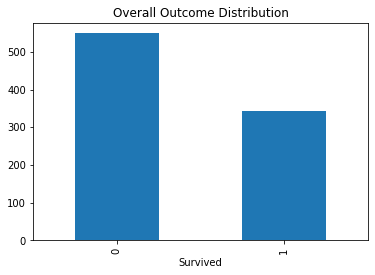

In [10]:
train.groupby("Survived").count()["PassengerId"].plot(kind="bar", title="Overall Outcome Distribution")
train.groupby("Survived").count()["PassengerId"]

Survived
0    489
1    217
Name: PassengerId, dtype: int64

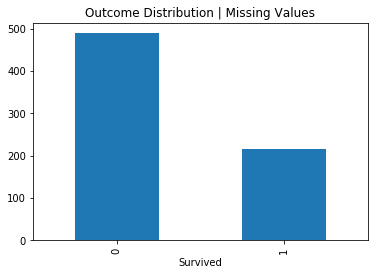

In [11]:
train[ (train["Age"].isna()) | (train["Cabin"].isna())].groupby("Survived").count()["PassengerId"].plot(kind="bar", title="Outcome Distribution | Missing Values")
train[ (train["Age"].isna()) | (train["Cabin"].isna())].groupby("Survived").count()["PassengerId"]

Survived
0     60
1    125
Name: PassengerId, dtype: int64

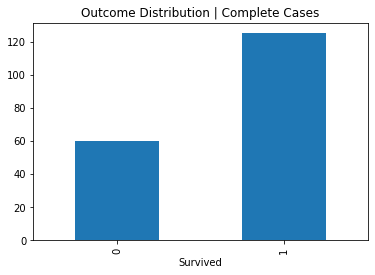

In [12]:
train[ (train["Age"].notna()) & (train["Cabin"].notna())].groupby("Survived").count()["PassengerId"].plot(kind="bar", title="Outcome Distribution | Complete Cases")
train[ (train["Age"].notna()) & (train["Cabin"].notna())].groupby("Survived").count()["PassengerId"]

**Conclusion**: The outcome distribution seems to be significantly different across the condition values are missings or complete. I conclude the fact that values are missing caries some preedictive information. Hence, dropping these columns / rows would result in a loss of information. One guess for the missing values is as most of them died, it was hard to reconstruct the information from them.

Next, I want to investigate the feature columns of the missing values to get a better idea about the imputation strategy. First, check the distribution of the features

### Impute Missing Values

#### Feature: Age

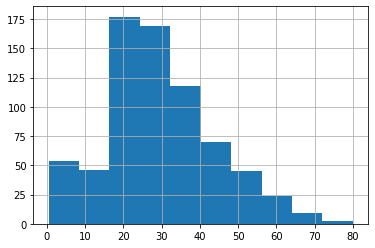

In [13]:
train["Age"].hist()

In [14]:
train["Age"].value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64

In [15]:
train["Age"].unique()

array([22.  , 38.  , 26.  , 35.  ,   nan, 54.  ,  2.  , 27.  , 14.  ,
        4.  , 58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  , 28.  ,
        8.  , 19.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  ,
       49.  , 29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  ,
       16.  , 25.  ,  0.83, 30.  , 33.  , 23.  , 24.  , 46.  , 59.  ,
       71.  , 37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 ,
       51.  , 55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  ,
       45.5 , 20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  ,
       60.  , 10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  ,
       70.  , 24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ])

In [16]:
train["Age"].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Age is a numerical feature. The distribution seems not too skewed with outliers. Mean and median are close to each other. It shoudlnt make that big of a difference. I'll go with simple median.

In [17]:
from sklearn.impute import SimpleImputer

In [18]:
imp_mean = SimpleImputer(strategy="median")
imp_mean.fit(train["Age"].values.reshape(-1,1))
train["Age"] = imp_mean.transform(train["Age"].values.reshape(-1,1))
test["Age"] = imp_mean.transform(test["Age"].values.reshape(-1,1))

In [19]:
print(train["Age"].isna().sum())
print(test["Age"].isna().sum())

0
0


#### Feature: Cabin

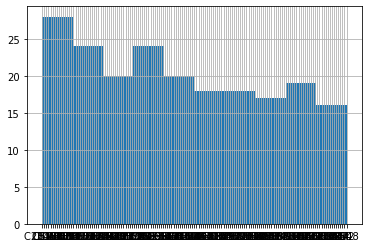

In [20]:
train["Cabin"].hist()

In [21]:
train["Cabin"].value_counts()

C23 C25 C27    4
B96 B98        4
G6             4
F33            3
C22 C26        3
              ..
E36            1
B80            1
A23            1
B42            1
C49            1
Name: Cabin, Length: 147, dtype: int64

In [22]:
train["Cabin"].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

It seems like it is a categorical feature. Hence, mean or median imputation doesn't bake sense. Also mode imputation doesn't make sense as the values are rather unique. 2 things moving forward:
* In this case it would make sense to introduced a additional class "unknown" to not loose information
* It seems like the cabin feature has a prefix, that could be a better feature. Maybe it is the cabin class.

In [23]:
# split feature
split_cabin = train["Cabin"].str.split("", 2, expand=True)
train["Cabin_class"] = split_cabin[1]
train["Cabin_number"] = split_cabin[2]


split_cabin = test["Cabin"].str.split("", 2, expand=True)
test["Cabin_class"] = split_cabin[1]
test["Cabin_number"] = split_cabin[2]

In [24]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_class,Cabin_number
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,NaN,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,85
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,NaN,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,123
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,NaN,NaN


In [25]:
train["Cabin"].fillna(value="Uknown", inplace=True)
train["Cabin_class"].fillna(value="Uknown", inplace=True)
train["Cabin_number"].fillna(value="Uknown", inplace=True)
test["Cabin"].fillna(value="Uknown", inplace=True)
test["Cabin_class"].fillna(value="Uknown", inplace=True)
test["Cabin_number"].fillna(value="Uknown", inplace=True)

In [26]:
train.isna().sum()

PassengerId     0
Survived        0
Pclass          0
Name            0
Sex             0
Age             0
SibSp           0
Parch           0
Ticket          0
Fare            0
Cabin           0
Embarked        2
Cabin_class     0
Cabin_number    0
dtype: int64

#### Feature: Embarked

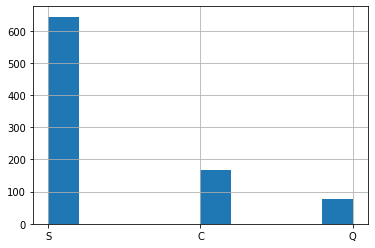

In [27]:
train["Embarked"].hist()

In [28]:
train["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [29]:
# imputing with the mode 
imp_mode = SimpleImputer(strategy="most_frequent")
imp_mode.fit(train["Embarked"].values.reshape(-1,1))
train["Embarked"] = imp_mode.transform(train["Embarked"].values.reshape(-1,1))
test["Embarked"] = imp_mode.transform(test["Embarked"].values.reshape(-1,1))

In [30]:
train.isna().sum()

PassengerId     0
Survived        0
Pclass          0
Name            0
Sex             0
Age             0
SibSp           0
Parch           0
Ticket          0
Fare            0
Cabin           0
Embarked        0
Cabin_class     0
Cabin_number    0
dtype: int64

#### And we have no missing values anymore :-)

## 3. Feature Engineering & Preprocessing

In [31]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_class,Cabin_number
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Uknown,S,Uknown,Uknown
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,85
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Uknown,S,Uknown,Uknown
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,123
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Uknown,S,Uknown,Uknown
5,6,0,3,"Moran, Mr. James",male,28.0,0,0,330877,8.4583,Uknown,Q,Uknown,Uknown
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,E,46
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,Uknown,S,Uknown,Uknown
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,Uknown,S,Uknown,Uknown
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,Uknown,C,Uknown,Uknown


In [32]:
train["Ticket"].value_counts()[:20]

347082          7
CA. 2343        7
1601            7
347088          6
3101295         6
CA 2144         6
S.O.C. 14879    5
382652          5
113781          4
4133            4
19950           4
349909          4
347077          4
17421           4
LINE            4
113760          4
2666            4
PC 17757        4
W./C. 6608      4
110152          3
Name: Ticket, dtype: int64

It is unclear to me what that ticket feature is. I just leave it out first.

In [33]:
train["Name"].value_counts()

Cunningham, Mr. Alfred Fleming           1
Bostandyeff, Mr. Guentcho                1
Palsson, Miss. Stina Viola               1
Richards, Mrs. Sidney (Emily Hocking)    1
Sage, Miss. Constance Gladys             1
                                        ..
White, Mr. Percival Wayland              1
Markoff, Mr. Marin                       1
Hippach, Miss. Jean Gertrude             1
Albimona, Mr. Nassef Cassem              1
Eitemiller, Mr. George Floyd             1
Name: Name, Length: 891, dtype: int64

In [34]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_class,Cabin_number
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Uknown,S,Uknown,Uknown
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,85
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Uknown,S,Uknown,Uknown
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,123
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Uknown,S,Uknown,Uknown


In [35]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Cabin_class',
       'Cabin_number'],
      dtype='object')

In [36]:
feat_cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin_class']
y_col = ["Survived"]

In [61]:
X_tr = train.set_index("PassengerId")[feat_cols]
X_te = test.set_index("PassengerId")[feat_cols]

In [65]:
y_tr = train.set_index("PassengerId")[y_col]

In [66]:
from sklearn.preprocessing import LabelEncoder

In [67]:
le = LabelEncoder()
le.fit(X_tr["Sex"])
X_tr["Sex"] = le.transform(X_tr["Sex"])

In [68]:
X_te["Sex"] = le.transform(X_te["Sex"])

In [69]:
X_tr = pd.get_dummies(X_tr)
X_te = pd.get_dummies(X_te)

In [70]:
X_tr.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_class_A,Cabin_class_B,Cabin_class_C,Cabin_class_D,Cabin_class_E,Cabin_class_F,Cabin_class_G,Cabin_class_T,Cabin_class_Uknown
PassengerId,,,,,,,,,,,,,,,,,,
1,3,1,22.0,1,0,7.2500,0,0,1,0,0,0,0,0,0,0,0,1
2,1,0,38.0,1,0,71.2833,1,0,0,0,0,1,0,0,0,0,0,0
3,3,0,26.0,0,0,7.9250,0,0,1,0,0,0,0,0,0,0,0,1
4,1,0,35.0,1,0,53.1000,0,0,1,0,0,1,0,0,0,0,0,0
5,3,1,35.0,0,0,8.0500,0,0,1,0,0,0,0,0,0,0,0,1


## 4. Modeling

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

### Random Forest

In [45]:
model_RF_1 = RandomForestClassifier(n_estimators=64)
scores = cross_val_score(model_RF_1, X_tr, y_tr.values.ravel(), cv=5)
scores.mean()

0.8126653538015459

In [46]:
model_RF_2 = RandomForestClassifier(n_estimators=128)
scores = cross_val_score(model_RF_2, X_tr, y_tr.values.ravel(), cv=5)
scores.mean()

0.8014039358291957

In [47]:
model_RF_3 = RandomForestClassifier(n_estimators=16)
scores = cross_val_score(model_RF_3, X_tr, y_tr.values.ravel(), cv=5)
scores.mean()

0.7980646055890037

### Support Vector Machine

In [48]:
from sklearn.svm import SVC

In [49]:
model_svm = SVC(kernel="rbf")
scores = cross_val_score(model_svm, X_tr, y_tr.values.ravel(), cv=5)
scores.mean()

/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/patricktu/opt/anaconda3/

0.7072658679538562

In [50]:
model_svm_2 = SVC(kernel="linear")
scores = cross_val_score(model_svm_2, X_tr, y_tr.values.ravel(), cv=5)
scores.mean()

0.7856102606331613

### Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression

In [72]:
model_lg = LogisticRegression()
scores = cross_val_score(model_lg, X_tr, y_tr.values.ravel(), cv=5)
scores.mean()

/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: 

0.792402475789838

### Perceptron

In [55]:
from sklearn.neural_network import MLPClassifier

In [56]:
model_nn_1 = MLPClassifier(hidden_layer_sizes=30)
scores = cross_val_score(model_nn_1, X_tr, y_tr.values.ravel(), cv=5)
scores.mean()

/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and th

0.7800111852420057

In [57]:
model_nn_1 = MLPClassifier(hidden_layer_sizes=64)
scores = cross_val_score(model_nn_1, X_tr, y_tr.values.ravel(), cv=5)
scores.mean()

/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and th

0.7991697245217458

In [59]:
model_nn_2 = MLPClassifier(hidden_layer_sizes=128)
scores = cross_val_score(model_nn_2, X_tr, y_tr.values.ravel(), cv=5)
scores.mean()

/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.790230964253683

### Decision Tree